In [11]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = "../alpc_key.json"
assert cira.auth.check_keys()

#symbols = ["ETH/USD", "DOGE/USD", "BTC/USD"]
symbols = ["AAPL", "GOOGL", "MSFT", "AMZN", "NFLX", "TSLA", "META", "SPOT"]
prices = pd.DataFrame()
for sym in symbols: 
    SYMBOL = sym 
    SYM_HIST_FILE = f'./{sym.replace("/", "_")}.csv'

    stk = cira.Stock(sym)

    if not exists(SYM_HIST_FILE): # chacheing historical data  
        start = datetime(2016, 1, 1).date()
        end = datetime(2024,7,10).date()
        stk.save_historical_data(SYM_HIST_FILE, start, end)

    data = stk.load_historical_data(SYM_HIST_FILE)
    prices[sym.split("/")[0]] = data["open"]

#prices["USD"] = 1.0
#annual_inflation_rate = 0.033  # 3.3%
## Convert the annual inflation rate to a daily inflation rate
#daily_inflation_rate = np.power(1 + annual_inflation_rate, 1/365) - 1
#prices['USD'] = prices['USD'] * (1 - daily_inflation_rate) ** np.arange(len(prices))

prices.dropna(inplace=True)
prices.tail()

,AAPL,GOOGL,MSFT,AMZN,NFLX,TSLA,META,SPOT
timestamp,,,,,,,,
2024-07-02 04:00:00+00:00,216.15,182.050,453.20,197.28,673.54,218.89,500.76,314.02
2024-07-03 04:00:00+00:00,220.00,184.850,458.19,199.94,677.48,234.56,506.37,315.30
2024-07-05 04:00:00+00:00,221.65,185.855,459.61,198.65,682.51,249.81,511.60,315.00
2024-07-08 04:00:00+00:00,227.09,189.895,466.55,200.04,687.00,247.71,542.35,321.94
2024-07-09 04:00:00+00:00,227.93,190.310,467.00,199.40,690.00,251.00,533.75,315.26


<Axes: xlabel='timestamp'>

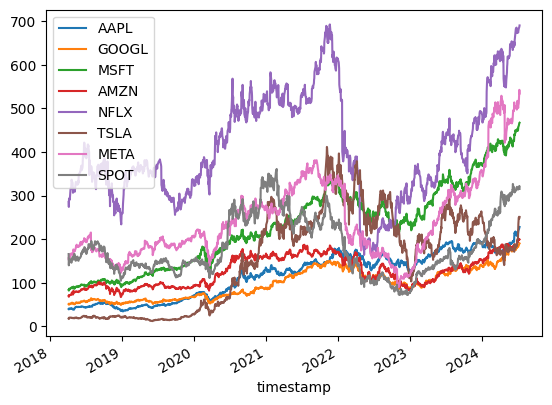

In [12]:
prices.plot()

In [13]:
split_prc = 0.7
train_data = prices.iloc[:int(len(prices)*split_prc)]
test_data =  prices.iloc[int(len(prices)*split_prc):]
print(len(prices), len(train_data), len(test_data))
assert len(prices) == len(train_data) + len(test_data)

1577 1103 474


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim



class PolicyNetwork(nn.Module):
    def __init__(self, number_of_assets:int=3):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(number_of_assets, 128)
        self.fc2 = nn.Linear(128, number_of_assets)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x)))

class Agent:
    def __init__(self, epsilon=0.1, number_of_assets:int=3):
        self.model = PolicyNetwork(number_of_assets=number_of_assets)
        self.optimizer = optim.Adam(self.model.parameters())
        self.epsilon = epsilon
        self.number_of_assets = number_of_assets

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.number_of_assets)  # choose a random action
        else:
            action_probs = self.model(state)
            action = torch.argmax(action_probs).item()  # choose the best action
        return action
    
    
    def update_policy(self, state, action, reward):
        self.optimizer.zero_grad()
        state = torch.tensor(state, dtype=torch.float32)
        action_probs = self.model(state)
        loss = -torch.log(action_probs[action]) * reward
        loss.backward()
        self.optimizer.step()


In [15]:

agent = Agent(0.65, len(prices.columns))
train_data.values[:5]

array([[ 39.63,  50.75,  83.68,  69.57, 285.45,  17.99, 156.23, 165.9 ],
       [ 38.98,  49.85,  82.07,  67.91, 273.95,  16.85, 151.71, 140.  ],
       [ 40.8 ,  52.26,  86.35,  72.1 , 293.15,  19.29, 161.23, 149.23],
       [ 40.42,  51.1 ,  85.47,  71.5 , 289.1 ,  20.07, 157.41, 146.29],
       [ 40.16,  50.94,  85.05,  71.25, 291.77,  20.02, 157.5 , 149.61]])

actions
3          314
0          189
2          150
5           95
1           90
7           90
4           89
6           85
Name: count, dtype: int64


<Axes: >

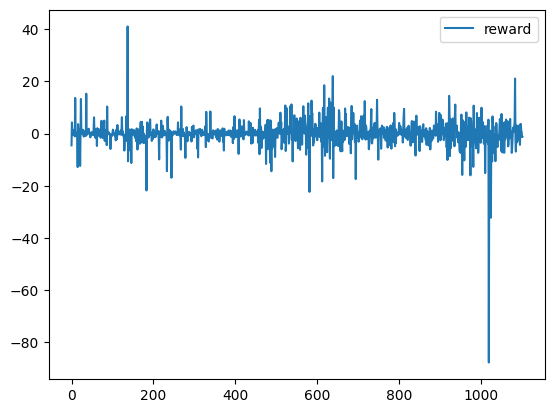

In [16]:
actions = [] 
rewards = []
for t in range(len(train_data)-1):
    state = train_data.iloc[t].values
    action = agent.get_action(state)
    actions.append(action)
    next_state = train_data.iloc[t+1].values
    reward = next_state[action] - state[action]
    #reward = max(0.0, reward)
    #print(state, action, next_state, reward)
    rewards.append(reward)
    agent.update_policy(state, action, reward)
print(pd.DataFrame({"actions":actions}).value_counts())
pd.DataFrame({"reward": rewards}).plot()

In [17]:
from numpy import ndarray
from pandas import DataFrame


class PolicyNetworkStrategy(cira.strategy.Strategy):
    def __init__(self, agent:Agent, allocation_amt = 0.1) -> None:
        super().__init__(name="PolicyNetwork")
        self.agent = agent
        self.allocation_amt = allocation_amt
        self.allocations = []
        self.cash_all = []

    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: ndarray, cash=float) -> ndarray: 
        self.cash_all.append(cash)
        actions = [] 
        for t in range(max(0, len(prices)-30),len(prices)-1):
            state = prices.iloc[t].values
            action = agent.get_action(state)
            actions.append(action)
            next_state = prices.iloc[t+1].values
            reward = next_state[action] - state[action]
            agent.update_policy(state, action, reward)
        _all = np.array([0]*len(prices.columns))
        _all = -0.008*portfolio
        if actions == []: 
            pass
            _all = np.array([0]*len(prices.columns))
        else: 
            action = actions[-1]
            _all[action] = ( cash/prices.iloc[-1].to_list()[action] ) * self.allocation_amt 
        self.allocations.append(_all)
        _all[np.isnan(_all)] = 0.0
        return _all.astype(float) 


    def selecting(self, prices:DataFrame) -> int: 
        """ select which asset will be evaluated, returns a index """
        pass 




<Axes: xlabel='timestamp'>

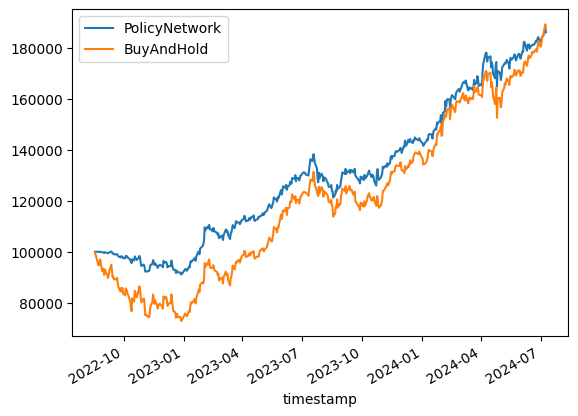

In [18]:
from cira.strategy import back_test_against_buy_and_hold, back_test
strat = PolicyNetworkStrategy(agent, allocation_amt=0.01)
back_test_against_buy_and_hold(strat, test_data, test_data, 100_000 ).plot()

<Axes: xlabel='timestamp'>

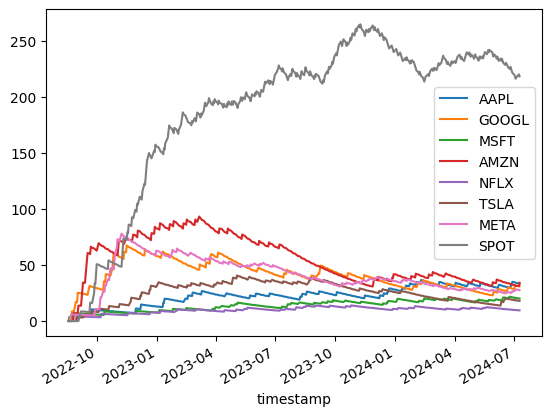

In [19]:
from collections import defaultdict
all_allocations = defaultdict(list)
for _all in strat.allocations:
    for i, sym in enumerate(test_data.keys()):
        all_allocations[sym].append(_all[i])



df_all = pd.DataFrame(all_allocations, index=test_data.index)
df_all = df_all.cumsum()
df_all.plot()

<Axes: xlabel='timestamp'>

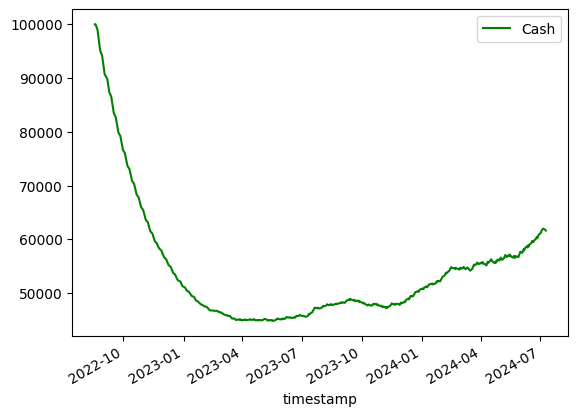

In [20]:
pd.DataFrame({"Cash":strat.cash_all}, index=test_data.index).plot(style="green")